# *stanscofi* package for collaborative filtering-based drug repurposing

This Python package proposes standard procedures to train, and to validate drug repurposing classifiers, along with assessing and visualizing their performance. It comprises method-agnostic training and validation procedures on several drug repurposing datasets present in the literature. 

The proper implementation of these steps is crucial in order to avoid data leakage, *i*.*e*., when the model is learnt over information that should be unavailable at prediction time. This can avoided by building training and validation sets which are weakly correlated with respect to the drug and disease feature vectors (function ``weakly_correlated_split`` in module **stanscofi.training_testing**). 

The main performance metric is the area under the curve (AUC), which estimates the diagnostic ability of a recommender system better than accuracy in imbalanced datasets, and the $F_\beta$ score (function ``compute_metrics`` in module **stanscofi.validation**). Since version 2.0.0, other ranking measures are implemented.

----------------------------------------------------------------------

### **Table of contents**

+ [I. Handling a *stanscofi.Dataset*](#I.-Handling-a-stanscofi.Dataset)

    - [I.1. Building a *stanscofi.Dataset* from existing datasets](#I.1.-Building-a-stanscofi.Dataset-from-existing-datasets)
    - [I.2. Build a *stanscofi.Dataset* from a custom dataset](#I.2.-Build-a-stanscofi.Dataset-from-a-custom-dataset)
    - [I.3. Visualization with a *stanscofi.Dataset*](#I.3.-Visualization-with-a-stanscofi.Dataset)
    
        * [I.3.a. Using ground truth annotations](#I.3.a.-Using-ground-truth-annotations)
        * [I.3.b. Using predicted annotations](#I.3.b.-Using-predicted-annotations)
+ [II. Create weakly correlated training and testing sets from a *stanscofi.Dataset*](#II.-Create-weakly-correlated-training-and-testing-sets-from-a-stanscofi.Dataset)
+ [III. Train a *stanscofi.Model*: Example of NMF on binary labelled dataset](#III.-Train-a-stanscofi.Model:-Example-of-NMF-on-binary-labelled-dataset)

    - [III.1. Fit a stanscofi.Model](#III.1.-Fit-a-stanscofi.Model)
    - [III.2. Predict from a *stanscofi.Model*](#III.2.-Predict-from-a-stanscofi.Model)
    - [III.3. Visualize the predictions](#III.3.-Visualize-the-predictions)
    - [III.4. Validate a fitted stanscofi.Model](#III.4.-Validate-a-fitted-stanscofi.Model)
    - [III.5. Perform cross-validation](#III.5.-Perform-cross-validation)
    - [III.6. Perform grid-search on hyperparameters](#III.6.-Perform-grid-search-on-hyperparameters)
    - [III.7. Extension to tri-labelled datasets](#III.7.-Extension-to-tri-labelled-datasets)
+ [IV. Preprocessing approaches](#IV.-Preprocessing-approaches)
    - [IV.1. Concatenate, mean-impute and center-standardize data](#IV.1.-Concatenate,-mean-impute-and-center-standardize-data)
    - [IV.2. Transcriptomic data](#IV.2.-Transcriptomic-data)
    - [IV.3. Perlman procedure](#IV.3.-Perlman-procedure)
+ [V. Train a stanscofi.Model: Example of LogisticRegression](#V.-Train-a-stanscofi.Model:-Example-of-LogisticRegression)
----------------------------------------------------------------------

In [3]:
import numpy as np
import pandas as pd
from time import time
from scipy.sparse import coo_array

import stanscofi

random_state = 124565
np.random.seed(random_state)

## I. Handling a *stanscofi.Dataset* 

A dataset for collaborative filtering-based drug repurposing comprises three matrices:

- A matrix filled with 0, 1, or -1 values, which represents the known associations between drugs and diseases. Typically, 1 (resp., -1) stands for a positive (resp., negative) drug-disease matching. Finally, 0 represents unknown (untested) drug-disease matchings.

- A matrix which encodes selected features for every drug involved in at least one matching in the previous matrix. Drug features might be the similarity of its chemical structure to the ones of other drugs, or the variation in gene activity which can be imputed to the treatment by that drug.

- A matrix which similarly encodes features for every disease involved in at least one matching in the previous matrix. In that case, features of a disease might correspond to the similarity of its associated phenotypes (*i*.*e*., observable characteristics associated with the disease), or the variation in gene activity which can be imputed to the presence of disease.

A dataset class with valuable methods (for the import and visualization) is implemented in *stanscofi.datasets*. The import of several drug repurposing datasets is implemented in *stanscofi.utils* (see [this GitHub repository](https://github.com/RECeSS-EU-Project/drug-repurposing-datasets) for more information about the datasets). 

This section shows how to use these methods.

In [4]:
import stanscofi.datasets
import stanscofi.utils

/home/kali/miniconda3/envs/stanscofi_min_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### I.1. Building a *stanscofi.Dataset* from existing datasets

The first option to create a *stanscofi.Dataset* is to import a known drug repurposing dataset and convert it into a  *stanscofi.Dataset*. The available ones are shown in the following table

Dataset   |    #drugs★ (#features) | #diseases★ (#features) |  #positive matchings | #negative matchings  | Sparsity number✦
---------------|---------------|---------------|--------------------------|-------------------------|----------------
Gottlieb / FDataset [[ref]](https://academic.oup.com/bioinformatics/article/34/11/1904/4820334)   |593 (593)      |313 (313)      |  1,933                    |    0                    | 1.04%
CDataset [[ref]](https://academic.oup.com/bioinformatics/article/34/11/1904/4820334)   |663 (663)      |409 (409)      |  2,532                    |     0                   | 0.93%
DNDataset [[ref]](https://academic.oup.com/bioinformatics/article/34/11/1904/4820334)  |550  (1,490)    |360  (4,516)    | 1,008                     |     0                   | 0.01%
LRSSL [[ref]](https://doi.org/10.1093/bioinformatics/btw770)      | 763 (2,049)    |681 (681)      | 3,051                     |      0                  | 0.59%
PREDICT-Gottlieb [[ref]](https://www.frontiersin.org/articles/10.3389/fphar.2021.784171/full)   |593 (1,779)     |313 (313)      |  1,933                    |    0                    | 1.04%
TRANSCRIPT [[ref]](https://doi.org/10.5281/zenodo.7982969) | 204 (12,096)  | 116 (12,096)  |   401                    |  11                     | 0.45%
PREDICT  [[ref]](https://doi.org/10.5281/zenodo.7982964)   | 1,351 (6,265) | 1,066 (2,914) |   5,624                  |  152                    | 0.34%

★ involved in at least one known drug-disease matching

✦ percentage of known matchings in the drug-disease association matrix (note that it takes into account *all* diseases and drugs in the dataset, even those which are not involved with any known matching)

Note that for PREDICT, per default, the downloaded version is the partial dataset publicly available on Zenodo. If the notebook *PREDICT_dataset.ipynb* in [this repository](https://github.com/RECeSS-EU-Project/drug-repurposing-datasets) was not run, then function *load_dataset* will return a dataset with the following characteristics

Dataset   |    #drugs★ (#features) | #diseases★ (#features) |  #positive matchings | #negative matchings  | Sparsity number✦
---------------|---------------|---------------|--------------------------|-------------------------|----------------
PREDICT (public) [[ref]](https://doi.org/10.5281/zenodo.7982964)   | 1,014 (1,642) | 941 (1,490) |  4,627                  |  132                    | 0.40%

In [5]:
available_datasets = ["Gottlieb", "Cdataset", "DNdataset", "LRSSL", "PREDICT_Gottlieb", "TRANSCRIPT", "PREDICT"]

Let us print the contents of the datasets, that should match the contents of the previous table.

In [6]:
for model_name in available_datasets:
    print("$ "+model_name)
    data_args = stanscofi.utils.load_dataset(model_name, save_folder="../datasets/")
    dataset = stanscofi.datasets.Dataset(**data_args)
    # Prints the summary of the dataset
    dataset.summary() 

$ Gottlieb
----------------------------------------------------------------------
* Rating matrix: 593 drugs x 313 diseases
Including 593 drugs and 313 diseases involved in at least one positive/negative rating
1933 positive, 0 negative, 183676 unlabeled (including 0 unavailable) drug-disease ratings
Sparsity: 1.04 percent (on drugs/diseases with at least one known rating 1.04)
-----------------------------------
* Feature matrices:
#Drug features: 593	Total #Drugs: 593
Missing features: 0.00 percent
#Disease features: 313	Total #Disease: 313
Missing features: 0.00 percent
----------------------------------------------------------------------

$ Cdataset
----------------------------------------------------------------------
* Rating matrix: 663 drugs x 409 diseases
Including 663 drugs and 409 diseases involved in at least one positive/negative rating
2532 positive, 0 negative, 268635 unlabeled (including 0 unavailable) drug-disease ratings
Sparsity: 0.93 percent (on drugs/diseases with

### I.2. Build a *stanscofi.Dataset* from a custom dataset

The second option to create a *stanscofi.Dataset* is to build one from scratch, using a matrix of ratings, a drug ("item") feature matrix and a disease ("user") feature matrix. Method ``.summary`` returns several measures of interest for the dataset (see ``help``).

In [7]:
di = stanscofi.utils.load_dataset("TRANSCRIPT", save_folder="../datasets/")

ratings = di["ratings"]
users = di["users"]
items = di["items"]

for df_name in ["ratings", "users", "items"]:
    print("$ "+df_name)
    print(eval(df_name).iloc[:5,:5])
    if (df_name=="ratings"):
        print("Values %s" % str(np.unique(eval(df_name).values)))
    print("Shape (%d, %d)" % eval(df_name).shape, "\n")

dataset = stanscofi.datasets.Dataset(ratings=ratings, users=users, items=items, 
                                    same_item_user_features=True, name="TRANSCRIPT <custom loading>")
print("$ "+dataset.name)
dataset.summary()

$ ratings
         C0346629  C2239176  C3553462  C0035235  C0032285
DB00091         0         0         0         0         0
DB00121         0         0         0         0         0
DB00126         0         0         0         0         0
DB00130         0         0         0         0         0
DB00133         0         0         0         0         0
Values [-1  0  1]
Shape (613, 151) 

$ users
       C0346629  C2239176  C3553462  C0035235  C0032285
A1CF        0.0       0.0       0.0       0.0       0.0
A2M         0.0       0.0       0.0       0.0       0.0
AACS        0.0       0.0       0.0       0.0       0.0
AADAC       0.0       0.0       0.0       0.0       0.0
AADAT       0.0       0.0       0.0       0.0       0.0
Shape (12096, 151) 

$ items
        DB00091   DB00121   DB00126  DB00130  DB00133
A1CF  -0.018267 -0.018267  0.000000      0.0      0.0
A2M    0.000000  0.000000 -0.122491      0.0      0.0
AACS   0.000000  0.000000  0.000000      0.0      0.0
AADAC  0.000000 

(613,
 151,
 204,
 116,
 401,
 11,
 92151,
 0,
 0.4451022546805959,
 1.7410412440838403,
 12096,
 0.0,
 12096,
 0.0)

### I.3. Visualization with a *stanscofi.Dataset*

Let us create a simple dataset (in the sense that positive and negative pairs are easily distinguishable from each other based on features). Each of the $N_f$ features for (item, user) pair feature vectors associated with positive ratings are drawn from a Gaussian distribution of mean $m=0.5$ and standard deviation $\sigma=1$, whereas those for negative ratings are drawn from from a Gaussian distribution of mean $m=-0.5$ and standard deviation $\sigma=1$. 

We generate for "drugs" and "diseases" two matrices of shape $(\lfloor N_f/2 \rfloor, N_\text{pos}+N_\text{neg})$, which are the concatenation of $N_\text{pos}$ positive and $N_\text{neg}$ negative pair feature vectors generated from Gaussian distributions. Thus there are $N_\text{pos}^2$ positive ratings (each "positive" disease with a "positive" drug), $N_\text{neg}^2$ negative ratings (*idem*), and the remainder is unknown (that is, $(N_\text{pos}+N_\text{neg})^2-N_\text{pos}^2-N_\text{neg}^2$ ratings).

The function which generates this dataset is *stanscofi.datasets.generate_dummy_dataset*, and might be useful for testing purposes.

In [8]:
## Parameters
npositive, nnegative, nfeatures, mean, std = 200, 50, 50, 0.5, 1
data_di = stanscofi.datasets.generate_dummy_dataset(npositive, nnegative, nfeatures, mean, std)

## Import it as a stanscofi.Dataset
data_di.update({"same_item_user_features":False, "name":"Dummy"})
dataset = stanscofi.datasets.Dataset(**data_di)
dataset.summary()

----------------------------------------------------------------------
* Rating matrix: 250 drugs x 250 diseases
Including 250 drugs and 250 diseases involved in at least one positive/negative rating
40000 positive, 2500 negative, 20000 unlabeled (including 0 unavailable) drug-disease ratings
Sparsity: 68.00 percent (on drugs/diseases with at least one known rating 68.00)
-----------------------------------
* Feature matrices:
#Drug features: 25	Total #Drugs: 250
Missing features: 0.00 percent
#Disease features: 25	Total #Disease: 250
Missing features: 0.00 percent
----------------------------------------------------------------------



(250,
 250,
 250,
 250,
 40000,
 2500,
 20000,
 0,
 67.99999999999987,
 68.0,
 25,
 0.0,
 25,
 0.0)

#### I.3.a. Using ground truth annotations

The method *visualize* in class *stanscofi.Dataset* plots a PCA that allows to visualize the drug-disease pairs associated with known or unknown matchings based on drug and disease features. The PCA is computed on the concatenation of (feature-wise) mean-imputed (in the presence of missing values), filtered (considering the Top-$N$ features in terms of cross-sample variance), and centered-standardized drug and disease feature matrices.

According to how we have built the dataset, one should expect that one square of the 2D plane contains negative pairs, another positive pairs, and unknown matching pairs are located outside of these two squares.

* Plot the dataset with only nonzero ground truth annotations (PCA)


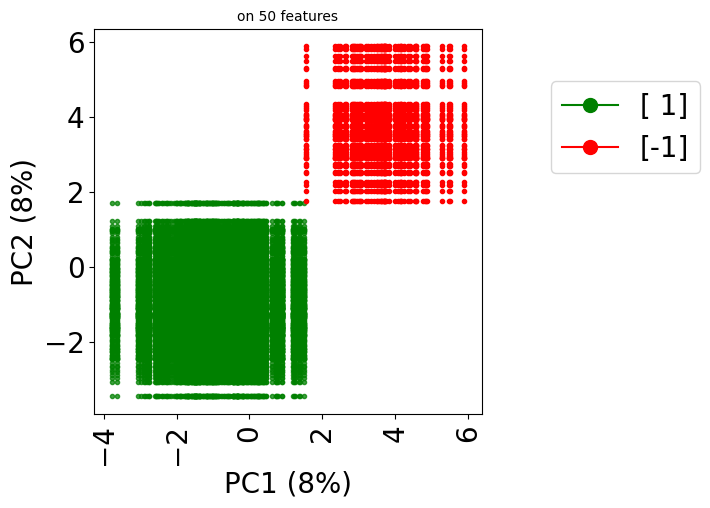

* Plot the dataset with only nonzero ground truth annotations (UMAP)


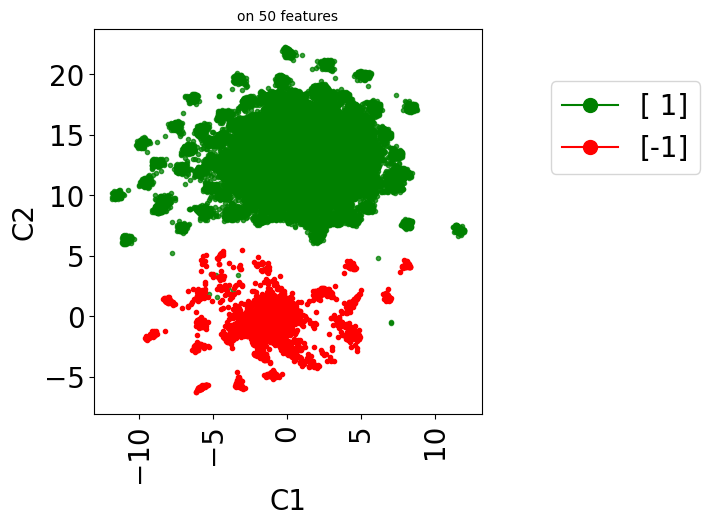

* Plot the dataset with all ground truth annotations (PCA)


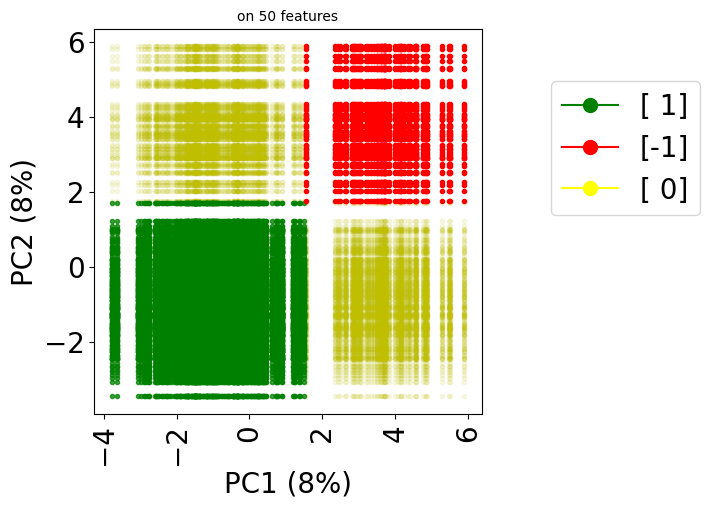

In [9]:
print("* Plot the dataset with only nonzero ground truth annotations (PCA)")
dataset.visualize(withzeros=False)

print("* Plot the dataset with only nonzero ground truth annotations (UMAP)")
dataset.visualize(withzeros=False, dimred_args={"n_neighbors": 5})

print("* Plot the dataset with all ground truth annotations (PCA)")
dataset.visualize(withzeros=True)

#### I.3.b. Using predicted annotations

Now, since the true labels of datapoints are usually unknown, let us assume that we made predictions about those labels, and that we want to observe how good those predictions are. Here, we generate random predictions, that is, we flip a coin, which assigns a negative label with probability $\pi=\frac{1}{16}$ (and a positive one otherwise).

The first plot shows the predicted labels (red for negative labels, green for positive ones) for each point, where the shape of the marker is related to the ground truth label for that point (``+`` if positive, ``v`` if negative, ``.`` if unknown).

The second plot emphasizes on prediction errors (green for correct predictions, red for incorrect ones), whereas the marker is still related to the ground truth label. It is restricted to datapoints (drug, disease pairs) which have a known matching (*i*.*e*., a rating in {-1,1}).

* Plot the dataset with random predictions


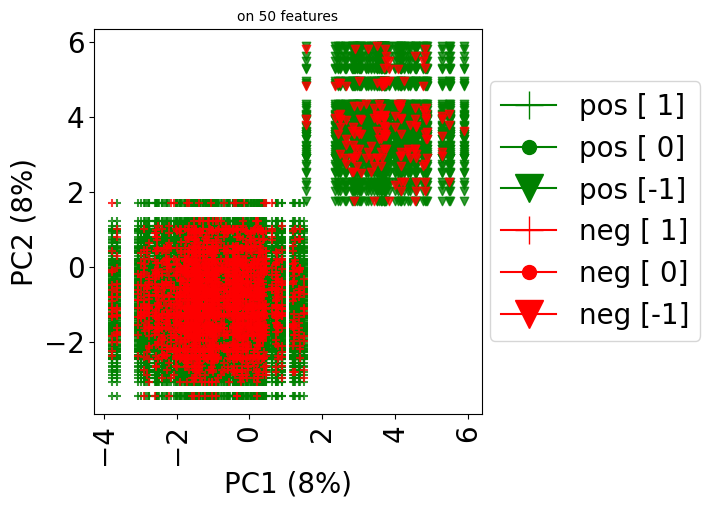

* Plot the dataset with random predictions and color by error


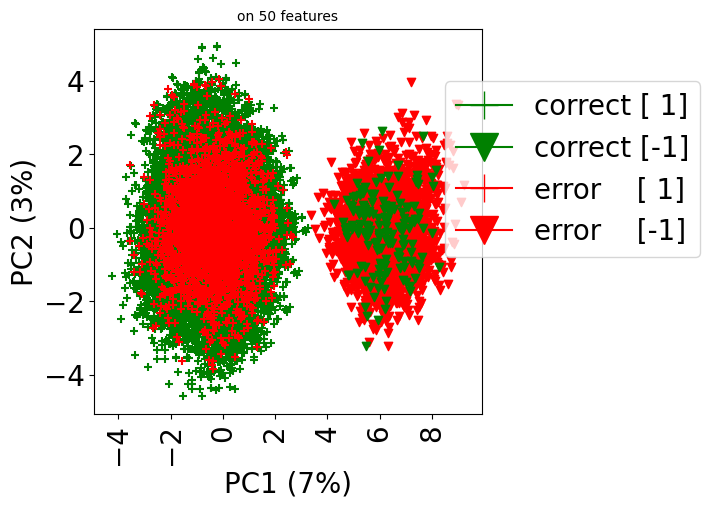

In [10]:
## Generate random class predictions
pi=1/16
predictions = coo_array(np.random.choice([-1,1], p=[pi,1-pi], size=np.prod(dataset.folds.shape)))

print("* Plot the dataset with random predictions")
dataset.visualize(predictions=predictions, withzeros=False)

print("* Plot the dataset with random predictions and color by error")
dataset.visualize(predictions=predictions, show_errors=True)

For more information, ``help(dataset.visualize)`` might be of help.

## II. Create weakly correlated training and testing sets from a *stanscofi.Dataset*

As previously mentioned at the start of this notebook, it is important to ensure that the training and testing datasets are weakly correlated. **stanscofi** proposes an computationally tractable approach which focuses on splitting items between training and testing sets (such that the set of items in both sets are disjoint *and* weakly correlated), based on hierarchical clustering. In a nutshell, it consists in splitting the set of items/drugs into two groups of clusters, such that the number of elements in the group assigned to testing is roughly a fixed proportion of the initial dataset (in terms of known ratings). A more refined splitting also allows to split the set of users/diseases. 

Then one can create a subset from an existing dataset using those folds using method *subset* in the class *stanscofi.Dataset*.

For more information, refer to ``help(stanscofi.training_testing.weakly_correlated_split)``.

In [11]:
import stanscofi.training_testing

<training_testing.traintest_validation_split> Find #clusters=332 in [2, 663] (200819 ~ 203375?)
<training_testing.traintest_validation_split> Find #clusters=498 in [333, 663] (200819 ~ 203375?)
Distances train/test: 16.697380	train/train: 0.811840	test/test: 1.678050
Training set
----------------------------------------------------------------------
* Rating matrix: 663 drugs x 409 diseases
Including 499 drugs and 328 diseases involved in at least one positive/negative rating
1872 positive, 0 negative, 269295 unlabeled (including 67076 unavailable) drug-disease ratings
Sparsity: 0.69 percent (on drugs/diseases with at least one known rating 1.14)
-----------------------------------
* Feature matrices:
#Drug features: 663	Total #Drugs: 663
Missing features: 0.00 percent
#Disease features: 409	Total #Disease: 409
Missing features: 0.00 percent
----------------------------------------------------------------------

Testing set
--------------------------------------------------------------

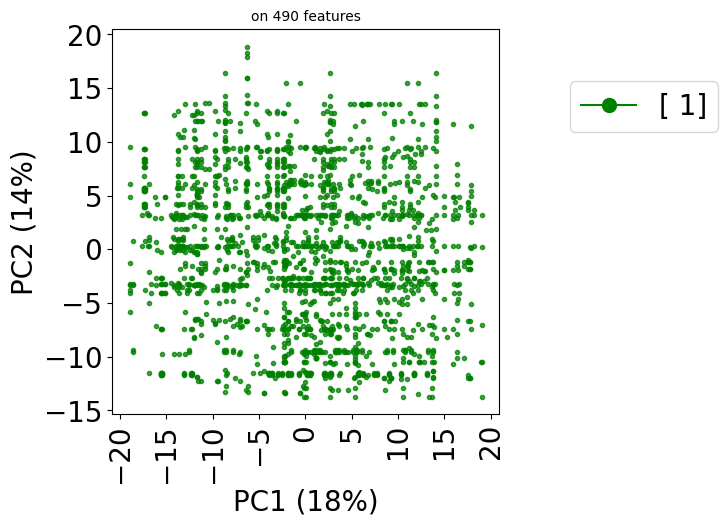

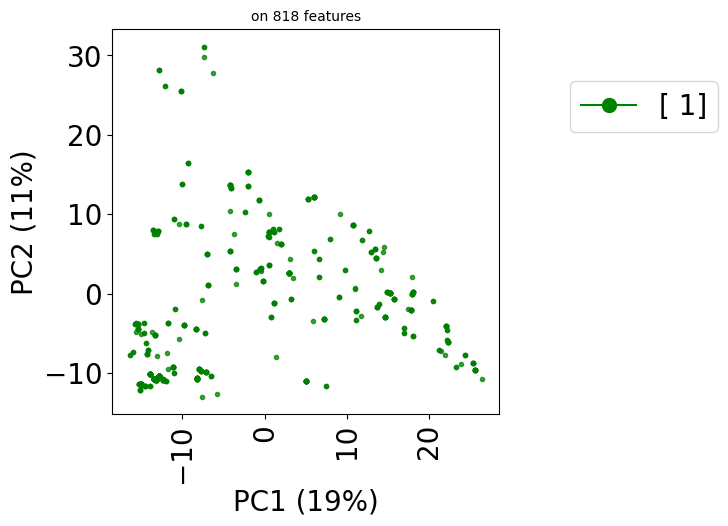

In [14]:
dataset_name = "Cdataset"
dataset = stanscofi.datasets.Dataset(**stanscofi.utils.load_dataset(dataset_name, save_folder="../datasets/"))
dataset.name = dataset_name 

metric = "cityblock" 
test_size = 0.25

## Generates training and testing datasets
(train_folds, test_folds), dists = stanscofi.training_testing.weakly_correlated_split(dataset, test_size, 
                                                                    early_stop=1, metric=metric, verbose=True)

print("Distances train/test: %f\ttrain/train: %f\ttest/test: %f" % dists)

train_dataset = dataset.subset(train_folds, subset_name="Train")
test_dataset = dataset.subset(test_folds, subset_name="Train")

print("Training set")
train_dataset.summary()
print("Testing set")
test_dataset.summary()

train_dataset.visualize(withzeros=False)
test_dataset.visualize(withzeros=False)

In [15]:
## check the percentage of known ratings in the training and testing sets
(
    train_dataset.folds.data.sum()*100/dataset.folds.data.sum(), 
    test_dataset.folds.data.sum()*100/dataset.folds.data.sum() ## should be close to/slightly less than 25%
)

(75.26395173453997, 24.73604826546003)

## III. Train a *stanscofi.Model*: Example of NMF on binary labelled dataset

A binary labelled dataset is a dataset in which ratings are either 1 (positive) or 0 (unknown), that is, there are no reported negative matchings. We first consider a method which only leverages the matrix of ratings, which is called Non-Negative Factorization (NMF). 

##### NMF model

The goal is to identify two matrices $W \in \mathbb{R}^{r \times N_s}$, $H \in \mathbb{R}^{r \times N_p}$ for a fixed value of $r \in \mathbb{N}^*$ such that the unknown full matrix of ratings $R$ satisfies
$$R = W^\top H\;.$$

##### Model fitting

Considering the known matrix of item-user matchings $A \in \{-1,0,1\}^{N_s \times N_p}$, matrices $W$ and $H$ are infered by optimizing on the following problem
$$W,H = \arg\min_{w,h} \frac{1}{2}\|A-w^\top h\|^2_F\;, \text{ where }\|\cdot\|_F \text{ is the Frobenius norm for matrices}\;.$$

Then, considering $R = W^\top H$, collaborative filtering can be performed by considering for any unlabeled value $A_{i,j} := \begin{cases} +1 & \text{ if } R_{i,j}>\theta\\-1 & \text{otherwise}\end{cases}$. In particular, this method can only be tested on the dataset it was trained on.

In [30]:
import stanscofi.models

### III.1. Fit a *stanscofi.Model*

First, we show how to fit the model on the whole training dataset.

In [31]:
from importlib import reload
reload(stanscofi.models)

## Model parameters
N_s, N_p = train_dataset.ratings.shape
grid_search = {"n_components": range(2, min(N_s, N_p))} # value of r
params = {"init":None, "solver":'cd', "beta_loss":'frobenius', "tol":0.0001, "max_iter":1500, 
          "random_state":random_state, "alpha_W":0.0, "alpha_H":'same', "l1_ratio":0.0, "verbose":0, 
          "shuffle":False}

params.update({"n_components": 10}) 

## Initialize the model
model = stanscofi.models.NMF(params)

## Fit the model on the whole training dataset (with a fixed random seed)
model.fit(train_dataset, seed=random_state)

### III.2. Predict from a *stanscofi.Model*

Second, we show how to output scores (confidence scores in labelling the considered datapoint as positive), how to print information about those scores. Then, one can call method *classify* in order to output classes instead of scores. Given a score $s$ and a threshold $\theta$ (fed to the model using argument ``threshold``) the classification is performed as follows:
$$\begin{cases} 1 & \text{ if }s \geq \theta\:,\\ -1 & \text{ otherwise}\:.\end{cases}$$

In [ ]:
scores = model.predict_proba(train_dataset)
model.print_scores(scores)
predictions = model.predict(scores, threshold=0)
model.print_classification(predictions)

## Return the score-wise top k pairs: returns a list of (item id, user id, score)
lst_k = model.recommend_k_pairs(dataset, k=1) 
lst_thres = model.recommend_k_pairs(dataset, k=None, threshold=lst_k[0][-1]) ## lst_thres==lst_k
(len(lst_k), np.max([score for _,_,score in lst_thres]))

* Scores
499 unique items, 328 unique users
Scores: Min: 0.000000	Mean: 0.019407	Median: 0.000328	Max: 1.783911	Std: 0.099113

* Classification
499 unique items, 328 unique users
Positive class: 84318, Negative class: 0



### III.3. Visualize the predictions

Now we visualize the resulting predictions on the PCA plot

In [29]:
(dataset.folds.data.shape, train_dataset.folds.data.shape, scores.data.shape, predictions.data.shape) ## error

((204091,), (271167,), (84318,), (84318,))

In [21]:
train_dataset.visualize(predictions=predictions, withzeros=False)

AssertionError: 

In [ ]:
train_dataset.visualize(predictions=predictions, show_errors=True)

### III.4. Validate a fitted *stanscofi.Model*

The package automatically computes and plots relevant validation measures (AUC, $F_\beta$ score, precision-recall and receiver operating curves). The metrics are computed *per user / disease*.

In [18]:
import stanscofi.validation

The *area under the curve* (AUC) estimates the diagnostic ability of a recommender system better than accuracy in imbalanced datasets. The $F_\beta$-score quantifies the performance of the classifier in terms of precision and recall in recommendations. The parameter $\beta$ controls how much importance is given to precision with respect to recall (in particular, $\beta=1$ means equal importance). $k$ is the rank at which to consider a truncated ranking metric. All the metrics implemented in **stanscofi** (from version 2.0.0) are listed in ``metrics_list``.

In [19]:
metrics, plot_args = stanscofi.validation.compute_metrics(scores, predictions, train_dataset, 
                                metrics=stanscofi.validation.metrics_list, k=1, beta=1, verbose=False)
metrics 

,Avg. across users,Std
AUC,0.744756,0.200555
F_1.0,0.101013,0.145899


The first two plots are directly linked to the AUC and F$_\beta$ scores. The third figure allows to observe the distribution of scores (independently of parameter ``threshold`` in method ``.predict``. The last one allows to observe the proportion of each label with respect to the ground truth.

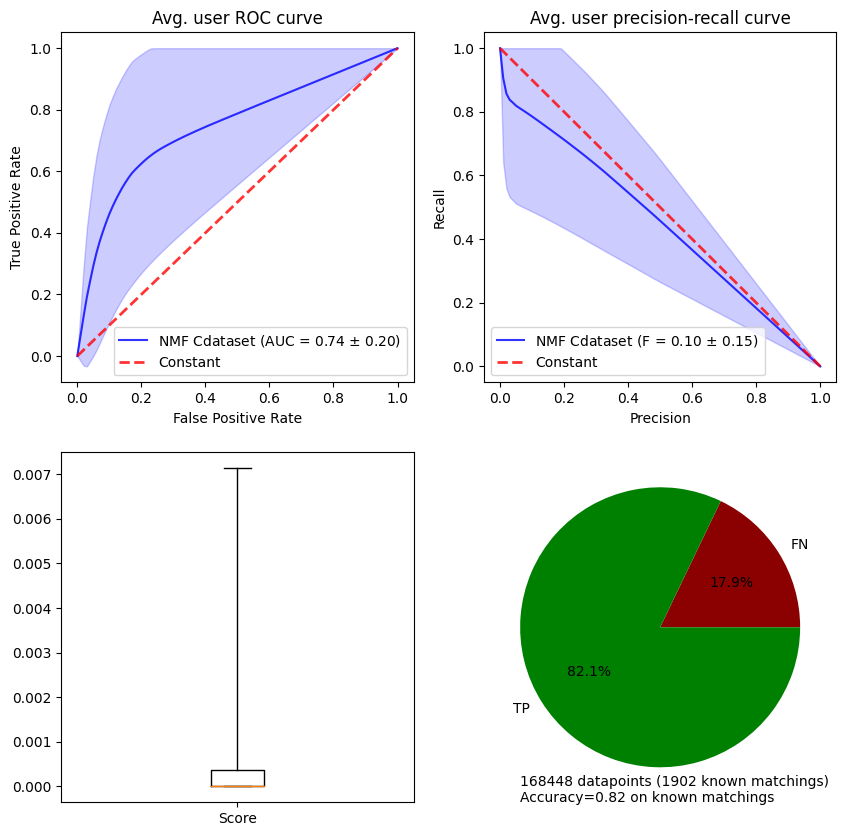

In [20]:
stanscofi.validation.plot_metrics(**plot_args, figsize=(10,10), model_name=model.name+" "+dataset.name)

### III.5. Perform cross-validation 

Training is more effective when combined with cross-validation. **stanscofi** allows to run cross-validation steps (on different splits) in parallel. This function is close to function ``sklearn.model_selection.cross_validate`` in **scikit-learn**, and contrary to the latter, uses our custom "per user" metrics.

In [21]:
njobs, nsplits=2, 3

start=time() 
results = stanscofi.training_testing.cv_training(stanscofi.models.NMF, params, train_dataset, 
    threshold=0, metric="AUC", beta=1, njobs=njobs, nsplits=nsplits, random_state=random_state, 
    cv_type="random", show_plots=False, verbose=True)
print("Elapsed time: %.2f sec. (njobs=%d)" % (time()-start, njobs))

print([k for k in results])

"Best AUC on Test %f (Best on Train %f)" % (
    np.max(results["test_metric"]), 
    results["train_metric"][np.argmax(results["test_metric"])]
)

5it [00:29,  5.82s/it]

Elapsed time: 29.29 sec. (njobs=1)


'AUC on Test 0.721400 (Train 0.719103)'

### III.6. Perform grid-search on hyperparameters 

The routine *grid_search* allows us to look for the best value of $r$ in NMF, by running a cross-validation learning phase for each value of $r$, and selecting the value of $r$ which achieved the highest score across all cross-validation steps. 

This function is close to function ``sklearn.model_selection.GridSearchCV`` in **scikit-learn**, and contrary to the latter, uses our custom "per user" metrics.

In [22]:
N_s, N_p = train_dataset.ratings.shape
grid_search = {"n_components": range(2, min(N_s, N_p)//3, 10)}
grid_search

{'n_components': range(2, 109, 10)}

In [23]:
best_params, best_estimator, best_metrics = stanscofi.training_testing.grid_search(search_params, 
        stanscofi.models.NMF, params, train_dataset,  threshold=0, metric="AUC", njobs=2, nsplits=3, 
        random_state=1234, show_plots=random_state, verbose=True)

5it [00:00, 33.21it/s]
2023-06-28 07:43:24.830264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-28 07:43:24.858696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-28 07:43:24.986561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-28 07:43:25.266763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<training_testing.grid_search> [n_components=2] AUC on Test 0.594664 (Train 0.568908)


5it [00:00, 201.05it/s]


<training_testing.grid_search> [n_components=12] AUC on Test 0.725133 (Train 0.746457)


5it [00:00, 252.25it/s]


<training_testing.grid_search> [n_components=22] AUC on Test 0.772568 (Train 0.836484)


5it [00:00, 233.81it/s]


<training_testing.grid_search> [n_components=32] AUC on Test 0.818697 (Train 0.861050)


5it [00:00, 253.98it/s]


<training_testing.grid_search> [n_components=42] AUC on Test 0.846506 (Train 0.892475)


5it [00:00, 275.24it/s]


<training_testing.grid_search> [n_components=52] AUC on Test 0.878750 (Train 0.903719)


5it [00:00, 267.66it/s]


<training_testing.grid_search> [n_components=62] AUC on Test 0.903508 (Train 0.927572)


5it [00:00, 229.35it/s]


<training_testing.grid_search> [n_components=72] AUC on Test 0.910220 (Train 0.932242)


5it [00:00, 242.36it/s]


<training_testing.grid_search> [n_components=82] AUC on Test 0.990496 (Train 0.934637)


5it [00:00, 211.91it/s]


<training_testing.grid_search> [n_components=92] AUC on Test 0.997251 (Train 0.948718)


5it [00:00, 242.22it/s]


<training_testing.grid_search> [n_components=102] AUC on Test 0.998140 (Train 0.955040)


In [24]:
print(best_estimator) ## trained best model

print("Best AUC on Test %f (Train %f)" % (best_metrics["test_metric"], best_metrics["train_metric"]))
pd.DataFrame({"params": best_params}).T

AUC on Test 0.998140 (Train 0.955040)


,alpha_H,alpha_W,beta_loss,decision_threshold,init,l1_ratio,max_iter,n_components,random_state,shuffle,solver,tol,verbose
params,same,0.0,frobenius,0.005,None,0.0,1500,102,124565,False,cd,0.0001,0


### III.7. Extension to tri-labelled datasets

A tri-labelled dataset is a dataset in which ratings are either 1 (positive), -1 (negative) or 0 (unknown).

The functions and methods shown above actually also work in that case, as demonstrated on the dataset TRANSCRIPT. First, we generate the two training and testing datasets:

<training_testing.traintest_validation_split> The sets of items/drugs in the training/testing datasets are disjoint.
<training_testing.traintest_validation_split> The sets of users/diseases in the training/testing datasets are *not* disjoint.
<training_testing.traintest_validation_split> Distances:
              Train set  Test set
Train set  2.580957e-08  0.936628
Test set   9.366278e-01  0.669440

<training_testing.print_folds> train_folds: 143 unique drugs and 97 unique diseases and 291 ratings (70.63 perc.)
            0    1  -1
counts  13580  286   5

<training_testing.print_folds> test_folds: 61 unique drugs and 66 unique diseases and 121 ratings (29.37 perc.)
           0    1  -1
counts  3905  115   6


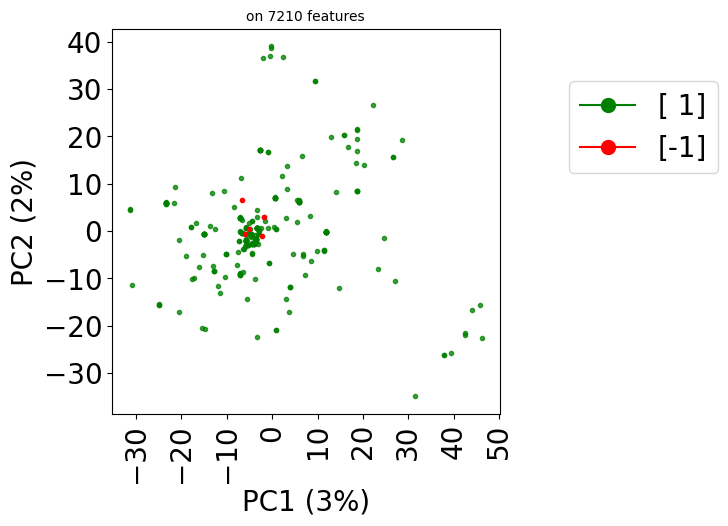

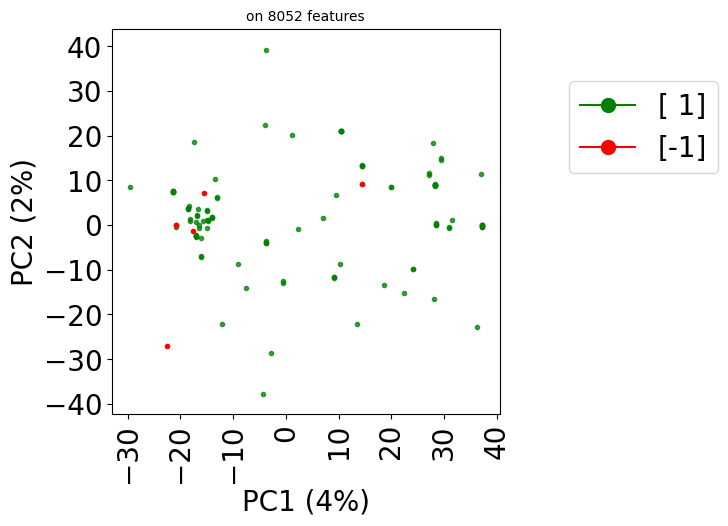

In [25]:
dataset_name = "TRANSCRIPT"
dataset = stanscofi.datasets.Dataset(**stanscofi.utils.load_dataset(dataset_name, save_folder="../datasets/"))
dataset.name = dataset_name 

metric = "cosine" 
test_size = 0.3

## Generates training and testing datasets
(train_folds, test_folds), dists = stanscofi.training_testing.weakly_correlated_split(dataset, test_size, 
                                                                                      early_stop=1, metric=metric)

print("Distances train/test: %f\ttrain/train: %f\ttest/test: %f" % dists)

train_dataset = dataset.subset(train_folds, subset_name="Train")
test_dataset = dataset.subset(test_folds, subset_name="Train")

print("Training set")
train_dataset.summary()
print("Testing set")
test_dataset.summary()

train_dataset.visualize(withzeros=False, dimred_args={"n_neighbors": 10})
test_dataset.visualize(withzeros=False, dimred_args={"n_neighbors": 10})

Then we apply a grid search on the number of components to choose while training:

In [26]:
## Model parameters
N_s, N_p = train_dataset.ratings_mat.shape
params = {"init":None, "solver":'cd', "beta_loss":'frobenius', "tol":0.0001, "max_iter":2000, 
          "random_state":random_state, "alpha_W":0.0, "alpha_H":'same', "l1_ratio":0.0, "verbose":0, 
          "shuffle":False}
params.update({"n_components": min(N_s,N_p)//3, "decision_threshold": 1.02})

## Fit the model on the whole training dataset
nsplits=5
njobs=nsplits-1

## Choose between training on the whole dataset, applying cross-validation with default parameters
## or running a grid search on some of the parameters
training = ["whole", "cv", "gridsearch"][0]

## Whole training dataset
if (training=="whole"):
    model = stanscofi.models.NMF(params)
    model.fit(train_dataset)
    args = params
    cv = None
else:
    if (training=="cv"):
        ## Cross-validation
        results = stanscofi.training_testing.cv_training(stanscofi.models.NMF, params, train_dataset, 
            threshold=0, metric="AUC", beta=1, njobs=njobs, nsplits=nsplits, random_state=random_state, 
            cv_type="random", show_plots=False, verbose=True)
        model = results["models"][np.argmax(results["test_metric"])]
        args = params
        print("AUC on Test %f (Train %f)" % (
            np.max(results["test_metric"]), results["train_metric"][np.argmax(results["test_metric"])]
        ))
    else:
        ## Grid-search
        grid_search = {"n_components": [2,5,10]}
        best_params, best_estimator, best_metrics = stanscofi.training_testing.grid_search(search_params, 
            stanscofi.models.NMF, params, train_dataset, threshold=0, metric="AUC", njobs=njobs, nsplits=nsplits, 
            random_state=random_state, show_plots=False, verbose=True)
        model = best_estimator
        args = best_params
        print("AUC on Test %f (Train %f)" % (best_metrics["test_metric"], best_metrics["train_metric"]))
        
pd.DataFrame({"params": args}).T

5it [00:00, 452.56it/s]


<training_testing.grid_search> [decision_threshold=1.0] AUC on Test 0.832124 (Train 0.749660)


5it [00:00, 497.07it/s]


<training_testing.grid_search> [decision_threshold=1.01] AUC on Test 0.988982 (Train 0.885997)


5it [00:00, 635.29it/s]


<training_testing.grid_search> [decision_threshold=1.02] AUC on Test 0.994595 (Train 0.938867)
AUC on Test 0.994595 (Train 0.938867)


,alpha_H,alpha_W,beta_loss,decision_threshold,init,l1_ratio,max_iter,n_components,random_state,shuffle,solver,tol,verbose
params,same,0.0,frobenius,1.02,None,0.0,2000,32,124565,False,cd,0.0001,0


In order to compute metrics on datasets with more than two classes, the argument ``average='weighted'`` is fed to the AUC and F-score functions in **scikit-learn**. 

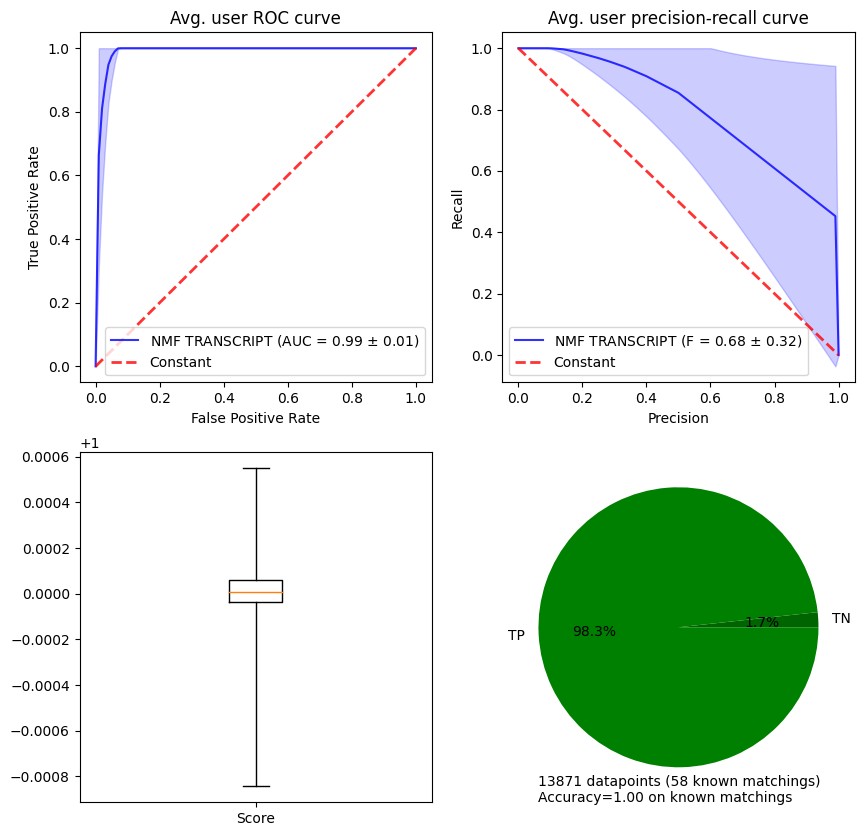

,Avg. across users,Std
AUC,0.990179,0.011297
F_1.0,0.680227,0.317056


In [29]:
## Validate
scores = model.predict_proba(test_dataset)
predictions = model.predict(scores, threshold=0)
metrics, plot_args = stanscofi.validation.compute_metrics(scores, predictions, test_dataset, 
                                metrics=("AUC", "Fscore"), k=1, beta=1, verbose=False)
stanscofi.validation.plot_metrics(**plot_args, figsize=(10,10), model_name=model.name+" "+dataset.name)
metrics

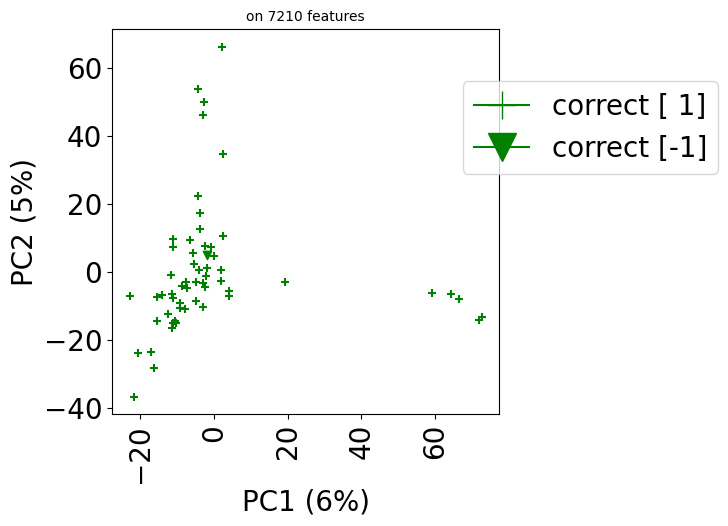

In [30]:
## Plot
test_dataset.visualize(predictions=predictions, show_errors=True, dimred_args={"n_neighbors": 10})

## IV. Preprocessing approaches

These functions allow to clean (missing or non finite values, etc.) and to prepare the drug repurposing dataset into a form that can be accepted by most models, that is, ($X$,$y$), where $X$ is of shape (n_ratings, n_features) and $y$ of shape (n_ratings, ). 

In [31]:
import stanscofi.preprocessing

### IV.1. Concatenate, mean impute and center-standardize data

It is actually the preprocessing approach used in order to plot the PCA in the class *stanscofi.Dataset*. It is the most basic approach when no assumption is made on the data.

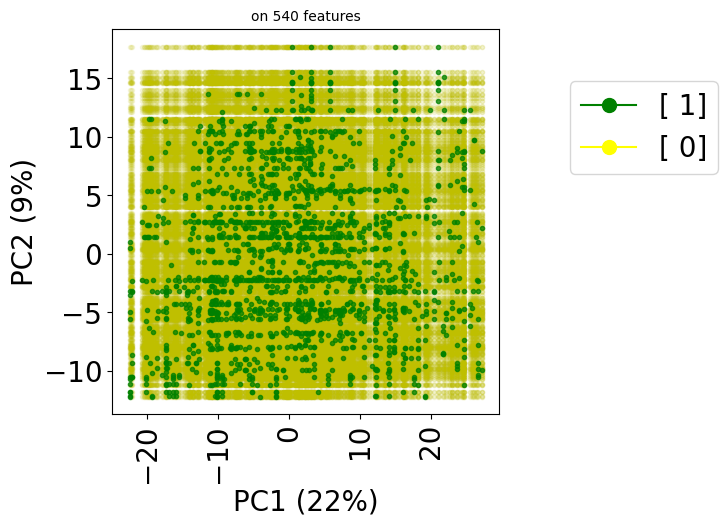

In [32]:
dataset = stanscofi.datasets.Dataset(**stanscofi.utils.load_dataset("Gottlieb", save_folder="../datasets/"))
dataset.visualize(withzeros=True)

In [33]:
start=time()

## With the same parameters as in stanscofi.Dataset.visualize
nvalues = np.prod(dataset.ratings.shape)
subselect_size = max(2,min(int(5e7)//nvalues+1, nvalues)) # Top-N features in terms of variance will be selected
X, y, _, _ = stanscofi.preprocessing.meanimputation_standardize(dataset, subset=subselect_size, inf=2)

print("Elapsed time %.2f sec" % (time()-start))
X.shape

Elapsed time 1.04 sec


(185609, 540)

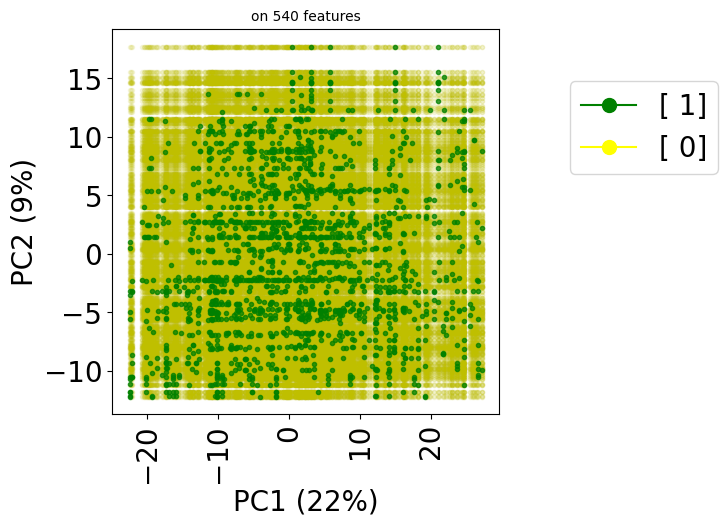

In [34]:
dataset.visualize(withzeros=True, X=X, y=y)

### IV.2. Transcriptomic data

However, for transcriptomic data (for instance, in TRANSCRIPT), the features are the same both in the drug and disease feature matrices. Indeed, features are genes here. We might be able to better exploit this by considering a drug-disease feature vector which is the list of coefficient-wise products of the corresponding drug and disease feature vectors. A product which is positive (resp., negative) means that the disease and the drug might have similar (resp., opposite) effects (and in the same direction) on the transcriptome, which is intuitively bad (resp., good) for a drug candidate for this disease.

Function ``same_feature_preprocessing`` can take as input any arithmetic operator such as ``+``, ``*``, ``-``.

In [35]:
dataset_name = "TRANSCRIPT"
dataset = stanscofi.datasets.Dataset(**stanscofi.utils.load_dataset(dataset_name, save_folder="../datasets/"))
data_di.update({"name": dataset_name, "same_item_user_features": True})

metric = "cosine" 
test_size = 0.3

## Generates training and testing datasets
(train_folds, test_folds), dists = stanscofi.training_testing.weakly_correlated_split(dataset, test_size, 
                                                                                      early_stop=1, metric=metric)

print("Distances train/test: %f\ttrain/train: %f\ttest/test: %f" % dists)

train_dataset = dataset.subset(train_folds, subset_name="Train")
test_dataset = dataset.subset(test_folds, subset_name="Train")

print("Training set")
train_dataset.summary()
print("Testing set")
test_dataset.summary()

<training_testing.traintest_validation_split> The sets of items/drugs in the training/testing datasets are disjoint.
<training_testing.traintest_validation_split> The sets of users/diseases in the training/testing datasets are *not* disjoint.
<training_testing.traintest_validation_split> Distances:
              Train set      Test set
Train set  1.490116e-08  9.366278e-01
Test set   9.366278e-01  1.490116e-08

<training_testing.print_folds> train_folds: 143 unique drugs and 97 unique diseases and 291 ratings (70.63 perc.)
            0    1  -1
counts  13580  286   5


In [36]:
start=time()

X, y = stanscofi.preprocessing.same_feature_preprocessing(train_dataset, "*")

print("Elapsed time %.2f sec" % (time()-start))
X.shape

Elapsed time 2.98 sec


(13871, 12096)

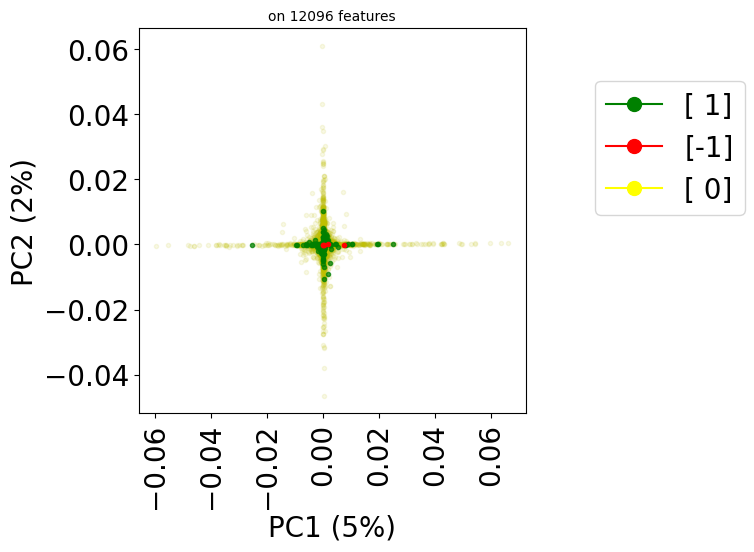

In [37]:
train_dataset.visualize(withzeros=True, X=X, y=y, dimred_args={"n_neighbors": 10})

### IV.3. [Perlman procedure](https://doi.org/10.1089/cmb.2010.0213)

The paper cited in the title has proposed an approach to combining drug-drug and disease-disease similarity matrices so that the final feature vectors are much shorter than the ones obtained by simply concatenating those matrices. This approach was shown to improve the performance of recommender systems, and was used in combination with logistic regression in the [PREDICT paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3159979/).

In particular, it can be used for the following datasets: "Gottlieb", "Cdataset", "DNdataset", "PREDICT_Gottlieb", "PREDICT".

In [38]:
dataset_name = "Gottlieb"
dataset = stanscofi.datasets.Dataset(**stanscofi.utils.load_dataset(dataset_name, save_folder="../datasets/"))
data_di.update({"name": dataset_name})

metric = "cityblock"
test_size = 0.3

## Generates training and testing datasets
(train_folds, test_folds), dists = stanscofi.training_testing.weakly_correlated_split(dataset, test_size, 
                                                                                      early_stop=1, metric=metric)

print("Distances train/test: %f\ttrain/train: %f\ttest/test: %f" % dists)

train_dataset = dataset.subset(train_folds, subset_name="Train")
test_dataset = dataset.subset(test_folds, subset_name="Train")

print("Training set")
train_dataset.summary()
print("Testing set")
test_dataset.summary()

<training_testing.traintest_validation_split> The sets of items/drugs in the training/testing datasets are disjoint.
<training_testing.traintest_validation_split> The sets of users/diseases in the training/testing datasets are *not* disjoint.
<training_testing.traintest_validation_split> Distances:
           Train set   Test set
Train set   0.333516  12.444803
Test set   12.444803   0.575126

<training_testing.print_folds> test_folds: 182 unique drugs and 176 unique diseases and 571 ratings (29.54 perc.)
            0    1  -1
counts  31461  571   0


In [39]:
start=time()

X, y = stanscofi.preprocessing.Perlman_procedure(test_dataset, njobs=10, verbose=True)

print("Elapsed time %.2f sec" % (time()-start))
X.shape

<preprocessing.Perlman_procedure> 1 item similarities, 1 user similarities
<preprocessing.Perlman_procedure> For 32032 ratings pairs, identified 1 features


  0%|                                                                          | 0/1 [00:00<?, ?it/s]

<preprocessing.Perlman_procedure> Considering item feature '{1}' and user feature '{1}' (10 jobs)


100%|██████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.52s/it]

Elapsed time 25.66 sec


(32032, 1)

/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

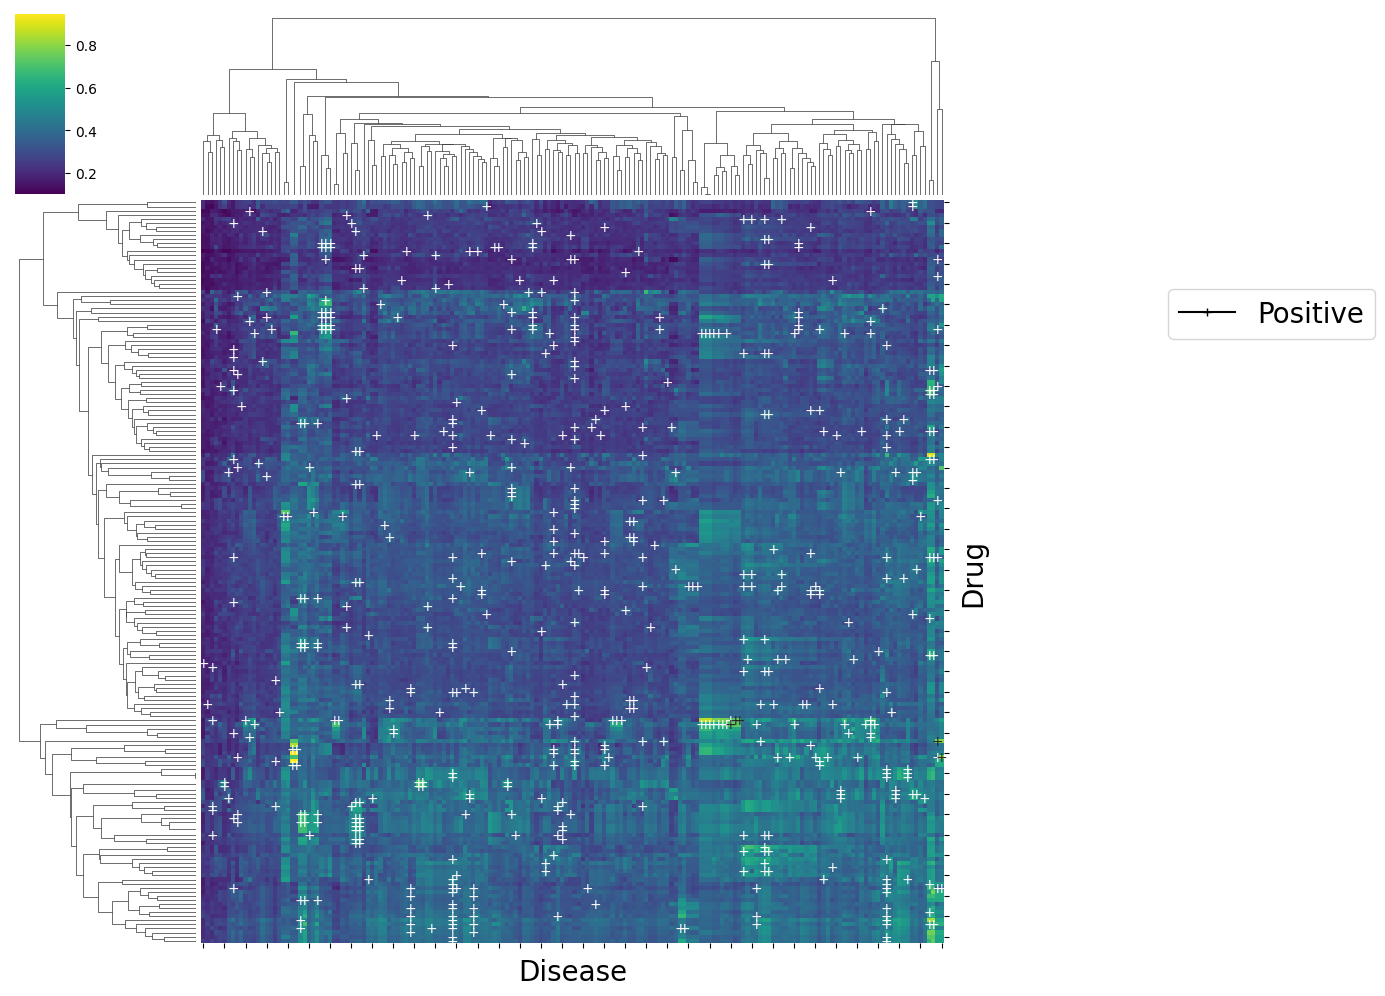

In [40]:
test_dataset.visualize(withzeros=True, X=X[:,0].reshape(-1,1), y=y, metric=metric, figsize=(10,10))

This approach can also be used for "LRSSL", "TRANSCRIPT" if a similarity matrix is created from the feature matrices.

<training_testing.traintest_validation_split> The sets of items/drugs in the training/testing datasets are disjoint.
<training_testing.traintest_validation_split> The sets of users/diseases in the training/testing datasets are *not* disjoint.
<training_testing.traintest_validation_split> Distances:
              Train set      Test set
Train set  1.110223e-15  4.349877e-01
Test set   4.349877e-01  1.332268e-15

<training_testing.print_folds> test_folds: 22 unique drugs and 26 unique diseases and 39 ratings (9.47 perc.)
          0   1  -1
counts  533  36   3
<preprocessing.Perlman_procedure> 1 item similarities, 1 user similarities
<preprocessing.Perlman_procedure> For 572 ratings pairs, identified 1 features


  0%|                                                                          | 0/1 [00:00<?, ?it/s]

<preprocessing.Perlman_procedure> Considering item feature '{1}' and user feature '{1}' (10 jobs)


100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


Elapsed time 0.27 sec (X shape 572, 1)


<Figure size 500x500 with 0 Axes>

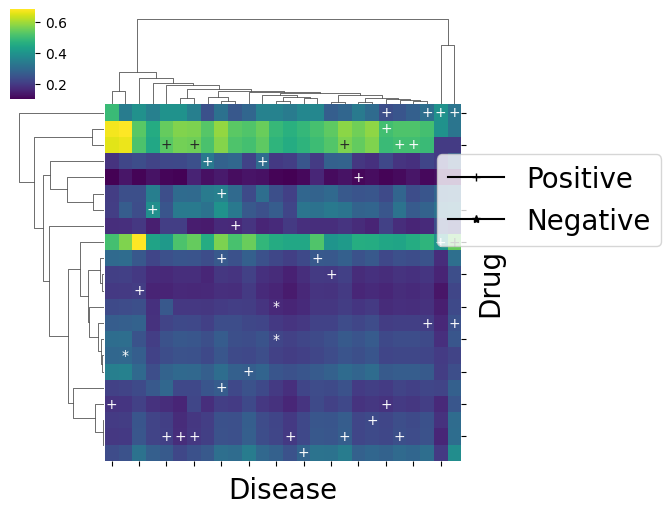

In [41]:
dataset_name = "TRANSCRIPT"
dataset = stanscofi.datasets.Dataset(**stanscofi.utils.load_dataset(dataset_name, save_folder="../datasets/"))
data_di.update({"name": dataset_name, "same_item_user_features": True})

metric = "cosine" 
test_size = 0.3

## Generates training and testing datasets
(train_folds, test_folds), dists = stanscofi.training_testing.weakly_correlated_split(dataset, test_size, 
                                                                                      early_stop=1, metric=metric)

print("Distances train/test: %f\ttrain/train: %f\ttest/test: %f" % dists)

train_dataset = dataset.subset(train_folds, subset_name="Train")
test_dataset = dataset.subset(test_folds, subset_name="Train")

print("Training set")
train_dataset.summary()
print("Testing set")
test_dataset.summary()

## Preprocessing (considering that there is a single similarity type ({1}))
start=time()
X, y = stanscofi.preprocessing.Perlman_procedure(test_dataset, njobs=10, verbose=True)
print("Elapsed time %.2f sec (X shape %d, %d)" % (time()-start, X.shape[0], X.shape[1]))

## Result
test_dataset.visualize(withzeros=True, X=X, y=y, metric=metric)
## Plots per dimension
if (X.shape[1]!=1):
    for i in range(X.shape[1]):
        print("* Dimension %d" %(i+1))
        test_dataset.visualize(withzeros=True, X=X[:,i].reshape(-1,1), y=y, metric=metric)

There is a function ``stanscofi.preprocessing.processing_XY`` which can call those functions.

## V. Train a *stanscofi.Model*: Example of LogisticRegression

Contrary to NMF, this model leverages the information from feature vectors.

##### Logistic model

If the considered model is a logistic model, then if the feature vector associated with drug-disease pair (i,j) is $x=[x_1, x_2, \dots, x_{L-1}, x_{L}]^\top$ of length $L$, let us denote the set of $L+1$ coefficients associated with positive class $C^+$ (resp., negative class $C^-$) in the class prediction model $\beta^{C^+}_0$, $\beta^{C^+}_1$, $\dots$, $\beta^{C^+}_{L-1}$, $\beta^{C^+}_{L}$ (resp., $\beta^{C^-}_0$, $\beta^{C^-}_1$, $\dots$, $\beta^{C^-}_{L-1}$, $\beta^{C^-}_{L}$). Then the probability of the associated cell of belonging to class $C$ is
$$Pr(x \text{ in } C | \beta^C_{\cdot}) := \sigma(\beta^C_0+\beta^C_1 x_1+\dots+\beta^C_{L-1} x_{L-1}+\beta^C_L x_L)\;, \text{ where } \sigma(x) := (1+\exp(-x))^{-1}\:.$$

##### Model fitting

Given N drug-disease pair feature vectors and associated ratings $(x^i, r^i), i=1,2,\dots$ (training data), the model fitting step consists to estimating the values of the $L$ coefficients $\beta^C_0$, $\beta^C_1$, $\dots$, $\beta^C_{L-1}$, $\beta^C_{L}$ for each class C. We consider a $\ell_1$ (also called lasso) regularization, that is, the estimated set of parameters $\beta^{\cdot}_{\cdot}$ that, for all classes and genes, would minimize the following function ($2L$ coefficients are estimated)
$$\text{loss}(\beta^{\cdot}_{\cdot}) := - \sum_{\text{class } C} \ \sum_{\substack{\text{pair }x^i,\\\text{ s.t. }r^i=C}} \  \log(Pr(x^i \text{ in } C | \beta^C_{\cdot}))+\sum_{\text{class } C} \ \sum_{\substack{\text{feature }\\f=1,2,\dots,L}} |\beta^{C}_{f}|\:.$$

To perform model fitting, we use the *Logistic_Regression* class in **scikit-learn**. It is a bit slow when the number of drug-disease pairs and features is too large. As such, it should only be used for testing purposes, and/or in combination with the preprocessing procedures shown above.

In [42]:
dataset_name = "TRANSCRIPT"
dataset = stanscofi.datasets.Dataset(**stanscofi.utils.load_dataset(dataset_name, save_folder="../datasets/"))
data_di.update({"name": dataset_name, "same_item_user_features": True})

metric = "cosine" 
test_size = 0.3

## Generates training and testing datasets
(train_folds, test_folds), dists = stanscofi.training_testing.weakly_correlated_split(dataset, test_size, 
                                                                                      early_stop=1, metric=metric)

print("Distances train/test: %f\ttrain/train: %f\ttest/test: %f" % dists)

train_dataset = dataset.subset(train_folds, subset_name="Train")
test_dataset = dataset.subset(test_folds, subset_name="Train")

print("Training set")
train_dataset.summary()
print("Testing set")
test_dataset.summary()

<training_testing.traintest_validation_split> The sets of items/drugs in the training/testing datasets are disjoint.
<training_testing.traintest_validation_split> The sets of users/diseases in the training/testing datasets are *not* disjoint.
<training_testing.traintest_validation_split> Distances:
              Train set  Test set
Train set  3.330669e-16  0.521504
Test set   5.215036e-01  0.199147

<training_testing.print_folds> train_folds: 161 unique drugs and 100 unique diseases and 289 ratings (70.15 perc.)
            0    1  -1
counts  15811  280   9

<training_testing.print_folds> test_folds: 43 unique drugs and 62 unique diseases and 123 ratings (29.85 perc.)
           0    1  -1
counts  2543  121   2


In [43]:
## Model parameters
params = {"penalty":'elasticnet', "C":1.0, "fit_intercept":True, "class_weight":"balanced", 
          "intercept_scaling":1., "random_state":random_state, "max_iter":2000, "tol": 1e-4, 
          "multi_class":'multinomial', "n_jobs": 1, "l1_ratio":1, "solver": "saga", 
          ## parameter subset allows to only consider Top-N features in terms of cross-sample variance for speed-up 
          "preprocessing_str": "same_feature_preprocessing", "subset": 100}
params.update({"decision_threshold": 0.75})

start=time()

results = stanscofi.training_testing.cv_training(stanscofi.models.LogisticRegression, params, train_dataset, 
            threshold=0, metric="AUC", beta=1, njobs=1, nsplits=3, random_state=random_state, 
            cv_type="random", show_plots=False, verbose=True)
model = results["models"][np.argmax(results["test_metric"])]

print("Elapsed time %.3f sec." % (time()-start))
print("AUC on Test %f (Train %f)" % (
    np.max(results["test_metric"]), results["train_metric"][np.argmax(results["test_metric"])]
))

0it [00:00, ?it/s]

Crossvalidation step #1/5


/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<validation.compute_metrics> Computed on #users=100, 10 ignored (10 perc)


1it [01:34, 94.97s/it]

<validation.compute_metrics> Computed on #users=100, 64 ignored (64 perc)
Crossvalidation step #2/5


/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<validation.compute_metrics> Computed on #users=100, 10 ignored (10 perc)


2it [03:11, 96.01s/it]

<validation.compute_metrics> Computed on #users=100, 61 ignored (61 perc)
Crossvalidation step #3/5
Crossvalidation step #3/5
<validation.compute_metrics> Computed on #users=329, 26 ignored ( 8 perc)
<validation.compute_metrics> Computed on #users=329, 146 ignored (44 perc)
Crossvalidation step #5/5
<validation.compute_metrics> Computed on #users=329, 17 ignored ( 5 perc)
<validation.compute_metrics> Computed on #users=329, 152 ignored (46 perc)
Crossvalidation step #4/5
<validation.compute_metrics> Computed on #users=329, 20 ignored ( 6 perc)
<validation.compute_metrics> Computed on #users=329, 163 ignored (50 perc)
Crossvalidation step #2/5
<validation.compute_metrics> Computed on #users=329, 14 ignored ( 4 perc)
<validation.compute_metrics> Computed on #users=329, 168 ignored (51 perc)
Crossvalidation step #2/5
<validation.compute_metrics> Computed on #users=329, 14 ignored ( 4 perc)
<validation.compute_metrics> Computed on #users=329, 168 ignored (51 perc)
Crossvalidation step #1/5

Crossvalidation step #4/5
<validation.compute_metrics> Computed on #users=329, 20 ignored ( 6 perc)
<validation.compute_metrics> Computed on #users=329, 163 ignored (50 perc)
Crossvalidation step #3/5
<validation.compute_metrics> Computed on #users=329, 26 ignored ( 8 perc)
<validation.compute_metrics> Computed on #users=329, 146 ignored (44 perc)
Crossvalidation step #3/5
<validation.compute_metrics> Computed on #users=329, 26 ignored ( 8 perc)
<validation.compute_metrics> Computed on #users=329, 146 ignored (44 perc)
Crossvalidation step #1/5
<validation.compute_metrics> Computed on #users=329, 29 ignored ( 9 perc)
<validation.compute_metrics> Computed on #users=329, 144 ignored (44 perc)
Crossvalidation step #5/5
<validation.compute_metrics> Computed on #users=329, 17 ignored ( 5 perc)
<validation.compute_metrics> Computed on #users=329, 152 ignored (46 perc)
Crossvalidation step #4/5
<validation.compute_metrics> Computed on #users=329, 20 ignored ( 6 perc)
<validation.compute_metri

/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<validation.compute_metrics> Computed on #users=100, 12 ignored (12 perc)


3it [04:46, 95.44s/it]

<validation.compute_metrics> Computed on #users=100, 62 ignored (62 perc)
Crossvalidation step #4/5


/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<validation.compute_metrics> Computed on #users=100, 15 ignored (15 perc)


4it [06:20, 94.95s/it]

<validation.compute_metrics> Computed on #users=100, 60 ignored (60 perc)
Crossvalidation step #5/5


/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<validation.compute_metrics> Computed on #users=100, 14 ignored (14 perc)


5it [07:45, 93.11s/it]

<validation.compute_metrics> Computed on #users=100, 61 ignored (61 perc)
Elapsed time 465.558 sec.
AUC on Test 0.504899 (Train 0.509506)


,params
C,1.0
class_weight,balanced
decision_threshold,0.75
fit_intercept,True
intercept_scaling,1.0
l1_ratio,1
max_iter,2000
multi_class,multinomial
n_jobs,1
penalty,elasticnet


In [45]:
## Predict the model on the testing dataset
scores = model.predict_proba(test_dataset)
model.print_scores(scores)
predictions = model.predict(scores, threshold=0)
model.print_classification(predictions)

* Scores
43 unique items, 62 unique users
Scores: Min: 0.362725	Mean: 0.590808	Median: 0.539931	Max: 1.000000	Std: 0.122993

* Classification
43 unique items, 62 unique users
Positive class: 270, Negative class: 2396



<validation.compute_metrics> Computed on #users=62, 2 ignored ( 3 perc)


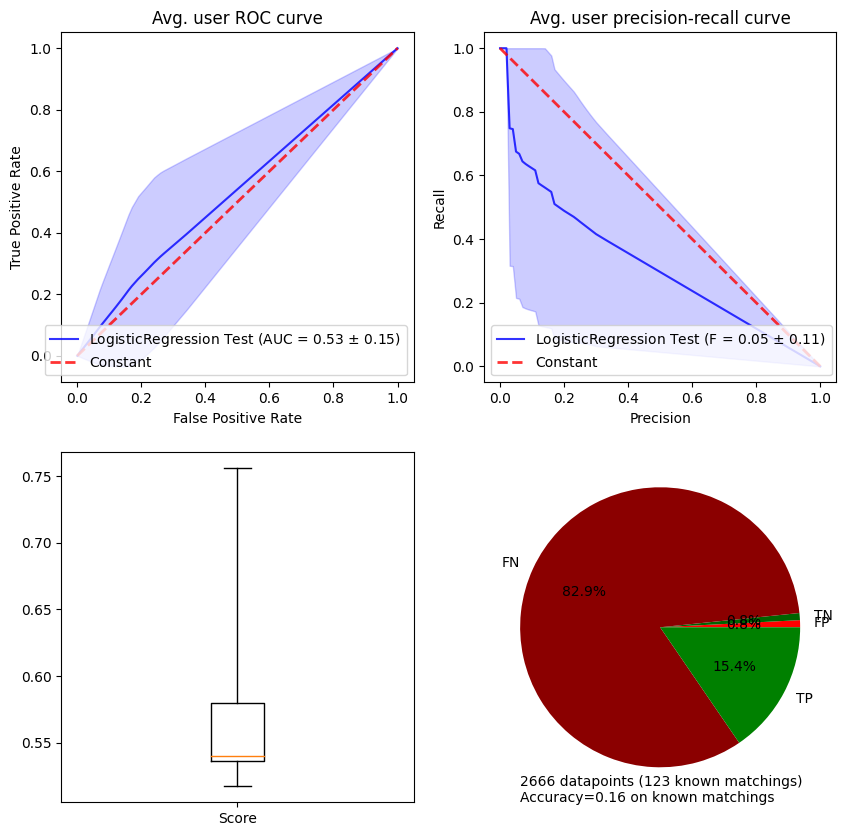

,Avg. across users,Std
AUC,0.532801,0.149063
F_1.0,0.053979,0.105078


In [46]:
## Validate the model on the testing dataset
metrics, plot_args = stanscofi.validation.compute_metrics(scores, predictions, test_dataset, 
                                metrics=("AUC", "Fscore"), k=1, beta=1, verbose=False)
stanscofi.validation.plot_metrics(**plot_args, figsize=(10,10), model_name=model.name+" "+dataset.name)
metrics

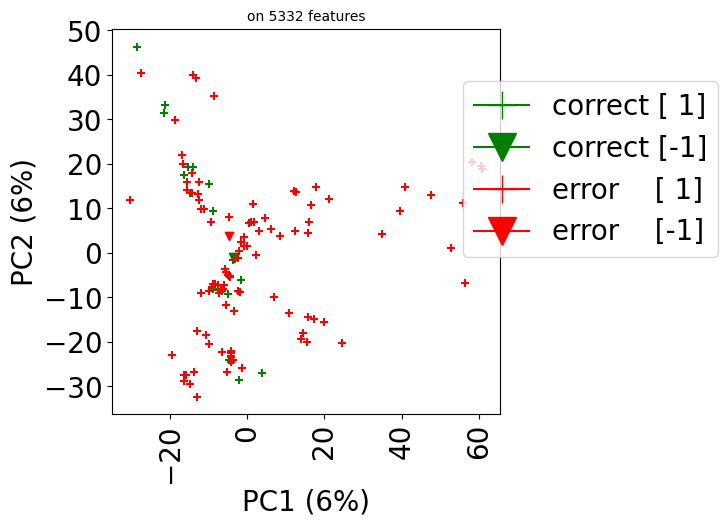

In [47]:
## Plot the model on the testing dataset
test_dataset.visualize(predictions=predictions, show_errors=True, dimred_args={"n_neighbors": 10})